In [2]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import eda_helper_functions

from sklearn.ensemble import IsolationForest

## 2. read the traing Data

In [3]:
file_path = r"C:\Users\mukti\Desktop\Flight_prediction_sagemaker\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-05-18,Delhi,Cochin,08:30:00,19:00:00,630,1.0,No Info,9205
1,Spicejet,2019-03-09,Banglore,New Delhi,10:20:00,18:15:00,475,1.0,No Info,7294
2,Jet Airways,2019-06-06,Delhi,Cochin,05:30:00,19:00:00,810,2.0,In-flight meal not included,10368
3,Jet Airways,2019-03-21,Delhi,Cochin,06:20:00,04:25:00,1325,2.0,No Info,12273
4,Jet Airways,2019-04-21,Banglore,Delhi,19:50:00,22:50:00,180,0.0,In-flight meal not included,4544
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-21,Kolkata,Banglore,09:35:00,23:35:00,840,1.0,No Info,14151
636,Jet Airways,2019-05-12,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,14151
637,Jet Airways,2019-06-03,Delhi,Cochin,15:00:00,04:25:00,805,1.0,No Info,14714
638,Multiple Carriers,2019-03-03,Delhi,Cochin,13:55:00,01:35:00,700,1.0,No Info,17057


In [5]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [6]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [7]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-05-18,Delhi,Cochin,2026-01-17 08:30:00,2026-01-17 19:00:00,630,1.0,No Info,9205
1,Spicejet,2019-03-09,Banglore,New Delhi,2026-01-17 10:20:00,2026-01-17 18:15:00,475,1.0,No Info,7294
2,Jet Airways,2019-06-06,Delhi,Cochin,2026-01-17 05:30:00,2026-01-17 19:00:00,810,2.0,In-flight meal not included,10368
3,Jet Airways,2019-03-21,Delhi,Cochin,2026-01-17 06:20:00,2026-01-17 04:25:00,1325,2.0,No Info,12273
4,Jet Airways,2019-04-21,Banglore,Delhi,2026-01-17 19:50:00,2026-01-17 22:50:00,180,0.0,In-flight meal not included,4544
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-21,Kolkata,Banglore,2026-01-17 09:35:00,2026-01-17 23:35:00,840,1.0,No Info,14151
636,Jet Airways,2019-05-12,Kolkata,Banglore,2026-01-17 09:35:00,2026-01-17 21:05:00,690,1.0,No Info,14151
637,Jet Airways,2019-06-03,Delhi,Cochin,2026-01-17 15:00:00,2026-01-17 04:25:00,805,1.0,No Info,14714
638,Multiple Carriers,2019-03-03,Delhi,Cochin,2026-01-17 13:55:00,2026-01-17 01:35:00,700,1.0,No Info,17057


## High level summary of data

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [10]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,634.664062,0.823438,9162.309375
std,491.445845,0.646464,5231.060670
min,75.000000,0.000000,1840.000000
25%,175.000000,0.000000,5085.250000
50%,527.500000,1.000000,8201.500000
75%,891.250000,1.000000,12437.750000
max,2295.000000,3.000000,62427.000000


In [11]:
train.describe(include="O")

,airline,source,destination,additional_info
count,640,640,640,640
unique,8,5,6,5
top,Jet Airways,Delhi,Cochin,No Info
freq,254,254,254,496


In [12]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,5
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,254,254,254,359.0,496


## High level analysis  of missing Values

In [13]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## High-level analysis of Outliers

In [14]:
forest = IsolationForest(n_estimators=10,random_state =42)

In [17]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	# .duration
	# .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
2,Jet Airways,2019-06-06,Delhi,Cochin,2026-01-17 05:30:00,2026-01-17 19:00:00,810,2.0,In-flight meal not included,10368,-1
3,Jet Airways,2019-03-21,Delhi,Cochin,2026-01-17 06:20:00,2026-01-17 04:25:00,1325,2.0,No Info,12273,-1
4,Jet Airways,2019-04-21,Banglore,Delhi,2026-01-17 19:50:00,2026-01-17 22:50:00,180,0.0,In-flight meal not included,4544,-1
5,Jet Airways,2019-06-12,Delhi,Cochin,2026-01-17 18:20:00,2026-01-17 19:00:00,1480,2.0,No Info,14300,-1
6,Spicejet,2019-03-27,Kolkata,Banglore,2026-01-17 22:20:00,2026-01-17 00:40:00,140,0.0,No Info,3847,-1
...,...,...,...,...,...,...,...,...,...,...,...
621,Air India,2019-06-24,Delhi,Cochin,2026-01-17 05:15:00,2026-01-17 06:50:00,1535,1.0,No Info,6587,-1
624,Spicejet,2019-03-24,Kolkata,Banglore,2026-01-17 22:20:00,2026-01-17 00:40:00,140,0.0,No Info,5831,-1
626,Jet Airways,2019-06-12,Delhi,Cochin,2026-01-17 22:50:00,2026-01-17 19:00:00,1210,1.0,No Info,14714,-1
627,Indigo,2019-05-03,Chennai,Kolkata,2026-01-17 19:35:00,2026-01-17 21:55:00,140,0.0,No Info,3597,-1


## Pair plots

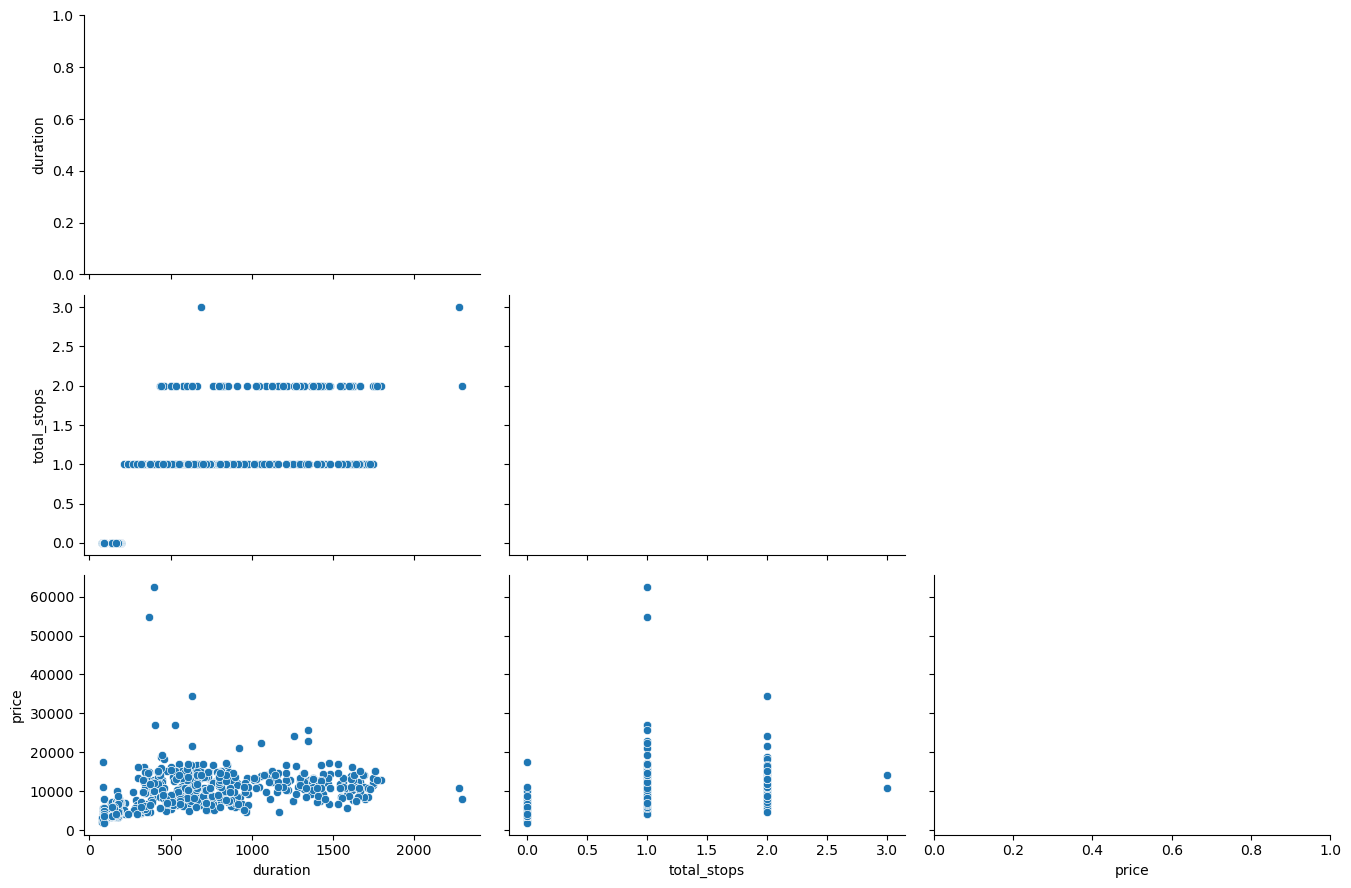

In [18]:
eda_helper_functions.pair_plots(train)

## Coreration Analysis

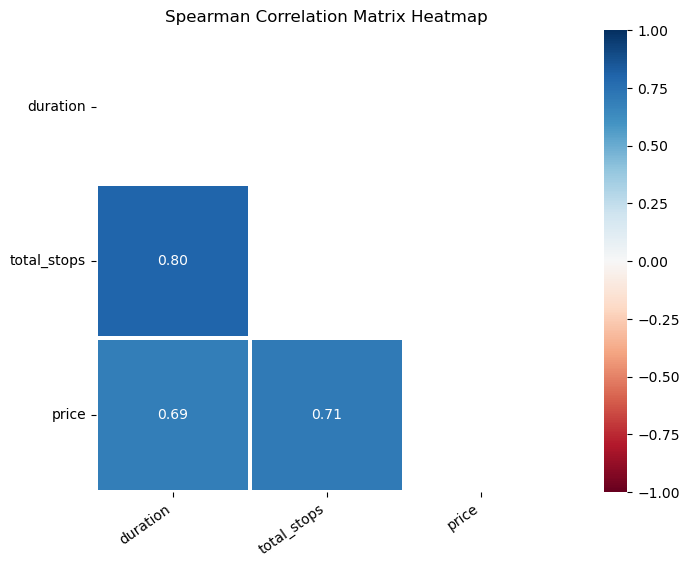

In [19]:
eda_helper_functions.correlation_heatmap(train)

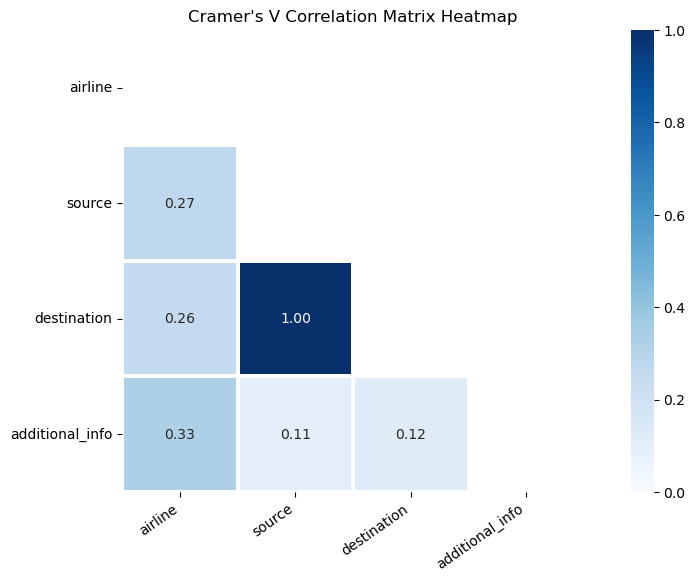

In [20]:
eda_helper_functions.cramersV_heatmap(train)

## Detailed Analysis

In [21]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [22]:
train.airline

0      Multiple Carriers
1               Spicejet
2            Jet Airways
3            Jet Airways
4            Jet Airways
             ...        
635          Jet Airways
636          Jet Airways
637          Jet Airways
638    Multiple Carriers
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [23]:
eda_helper_functions.cat_summary(train, "airline")

0      Multiple Carriers
1               Spicejet
2            Jet Airways
3            Jet Airways
4            Jet Airways
             ...        
635          Jet Airways
636          Jet Airways
637          Jet Airways
638    Multiple Carriers
639          Jet Airways
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,254


,count,percentage
category,,
Jet Airways,254,0.396875
Indigo,123,0.192188
Air India,91,0.142187
Multiple Carriers,61,0.095312
Spicejet,48,0.075000
Air Asia,31,0.048438
Vistara,24,0.037500
Goair,8,0.012500


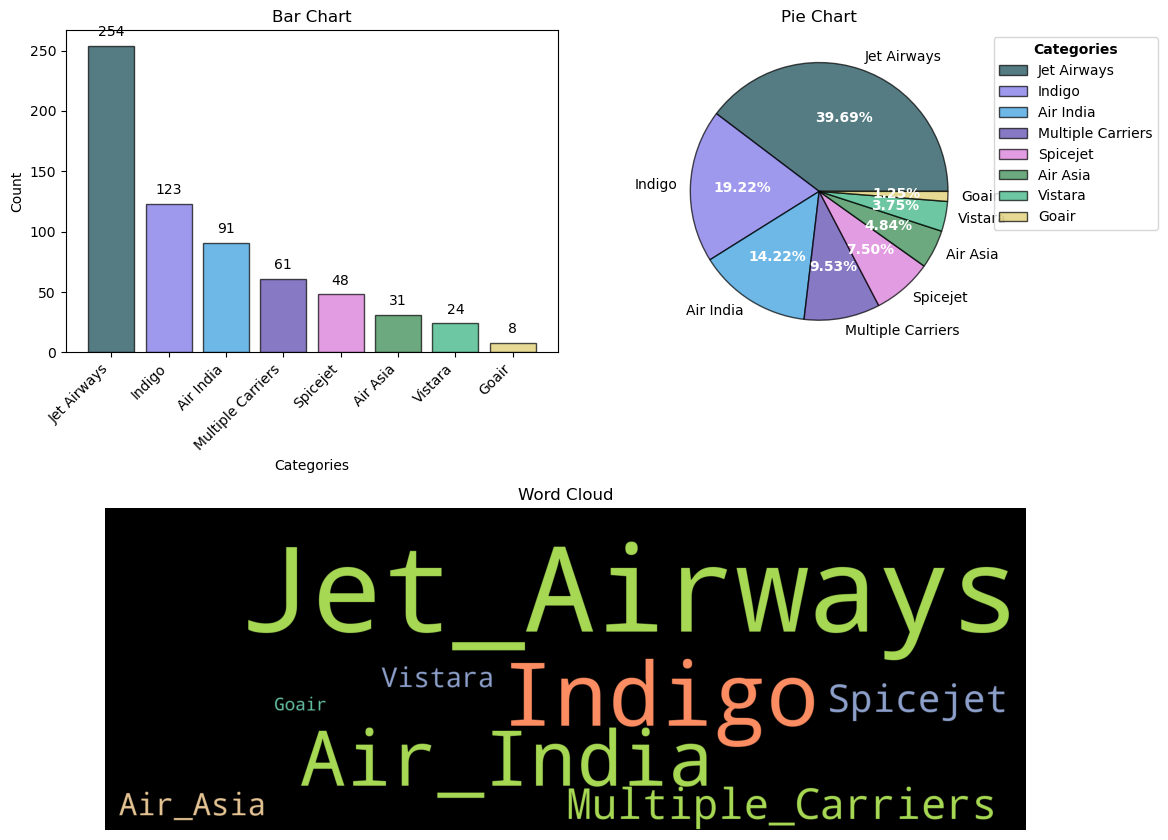

In [24]:
eda_helper_functions.cat_univar_plots(train, "airline")

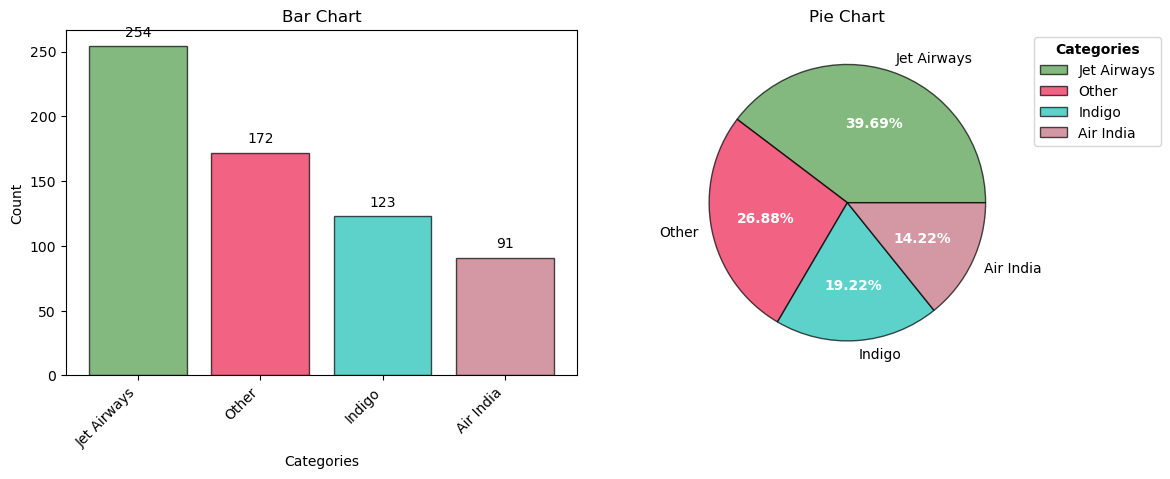

In [25]:
## if dont need wordcloudwith top 4 cat
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=3)

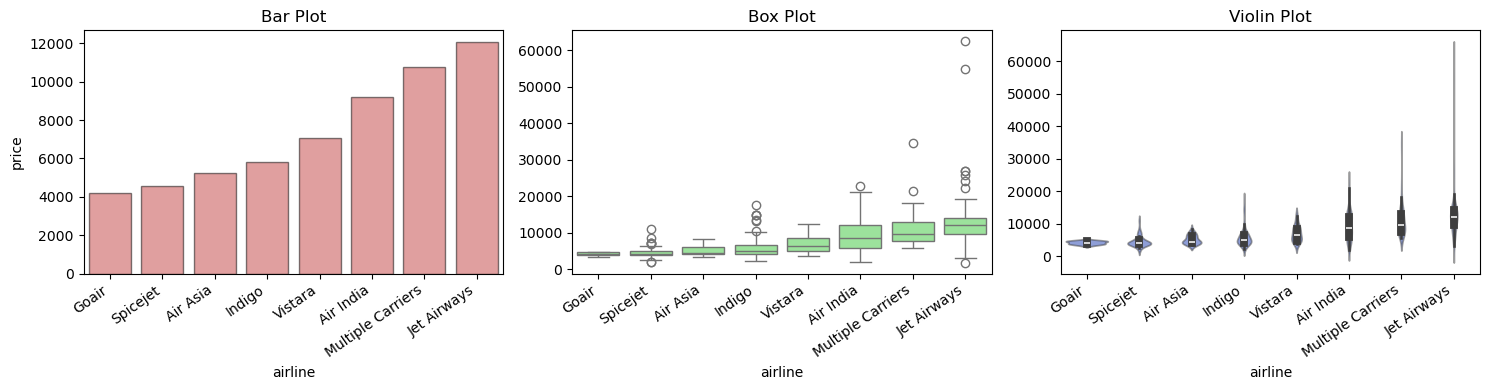

In [26]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

In [27]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 41.35816498715934
- p-value              : 5.358335680167276e-48
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 298.88628391004806
- p-value              : 1.0460656128291274e-60
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


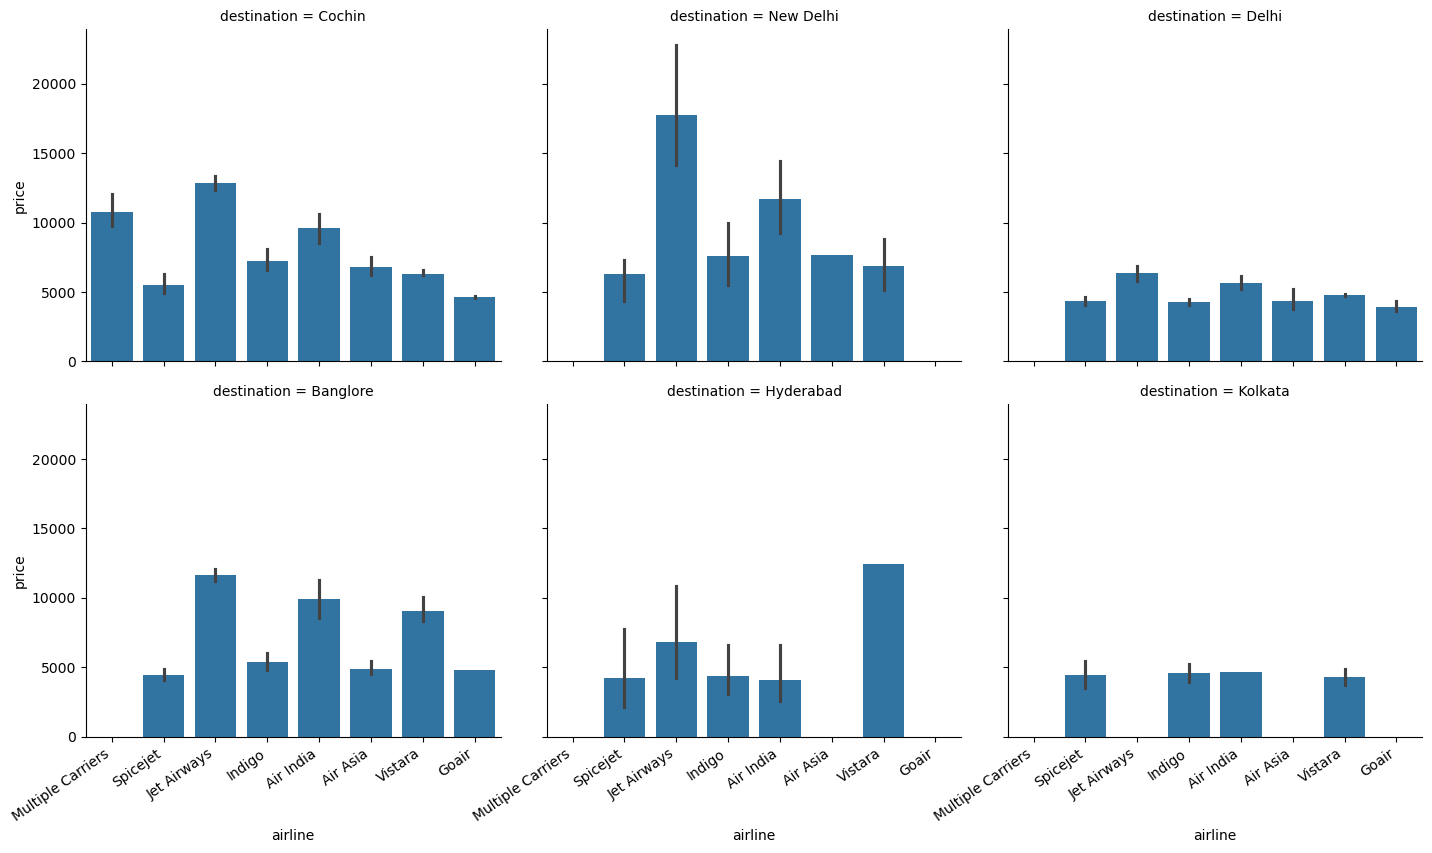

In [28]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
	eda_helper_functions.rotate_xlabels(ax)

##  8.2 date of journey

In [29]:
train.date_of_journey

0     2019-05-18
1     2019-03-09
2     2019-06-06
3     2019-03-21
4     2019-04-21
         ...    
635   2019-05-21
636   2019-05-12
637   2019-06-03
638   2019-03-03
639   2019-03-06
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

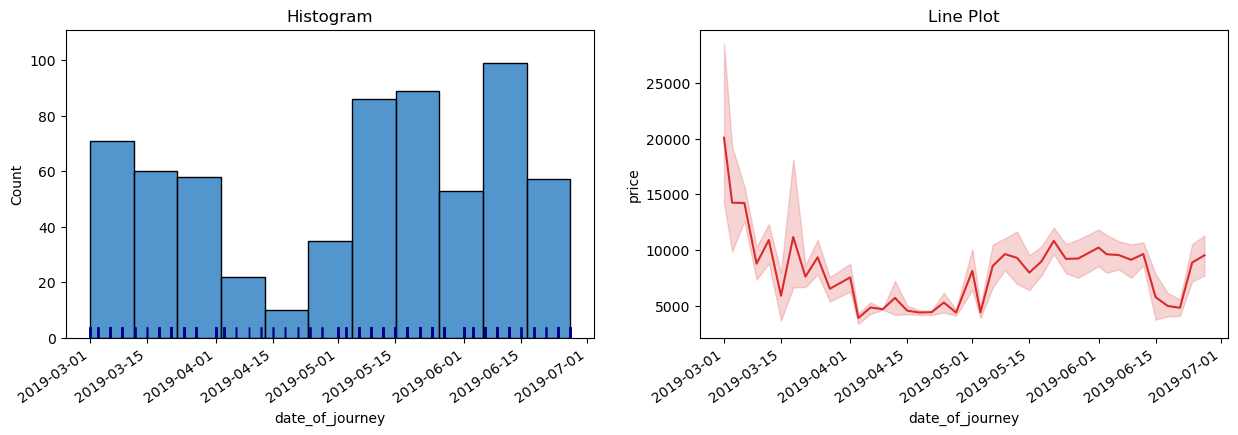

In [30]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

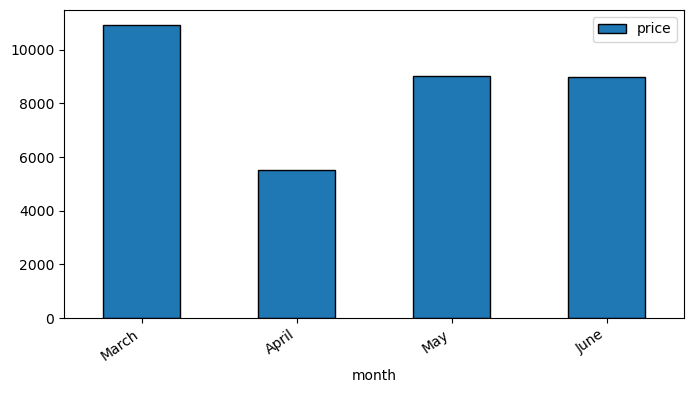

In [31]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

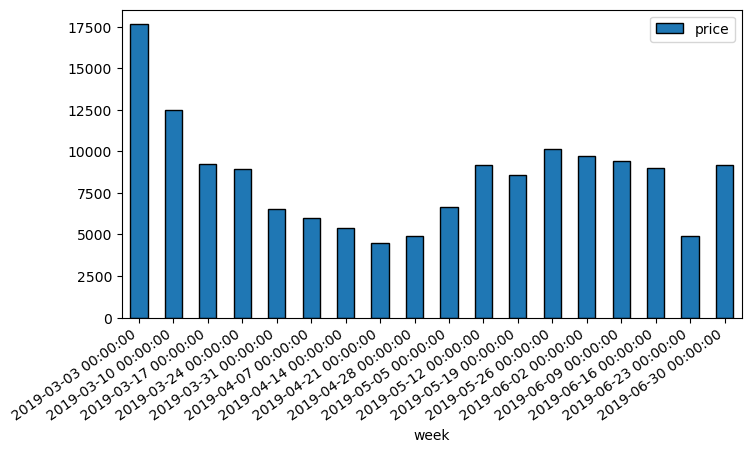

In [32]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

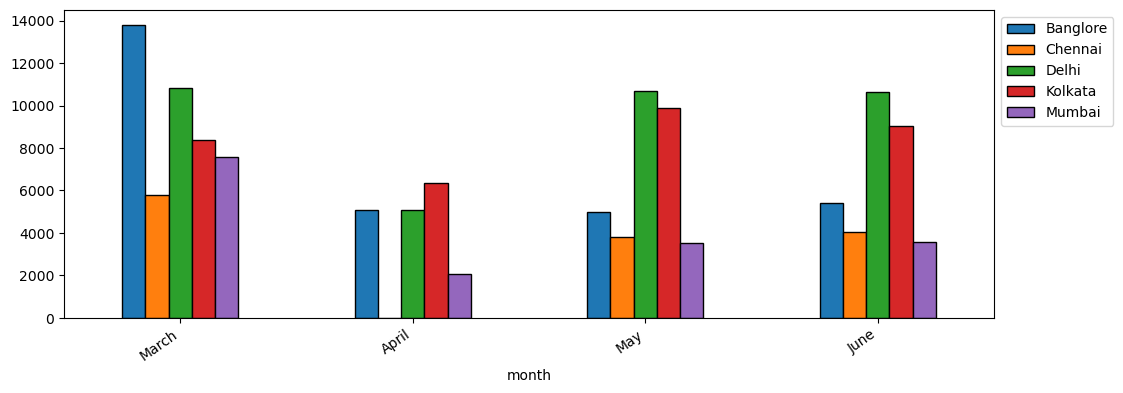

In [33]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

## dep time

In [34]:
train.dep_time

0     2026-01-17 08:30:00
1     2026-01-17 10:20:00
2     2026-01-17 05:30:00
3     2026-01-17 06:20:00
4     2026-01-17 19:50:00
              ...        
635   2026-01-17 09:35:00
636   2026-01-17 09:35:00
637   2026-01-17 15:00:00
638   2026-01-17 13:55:00
639   2026-01-17 18:15:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

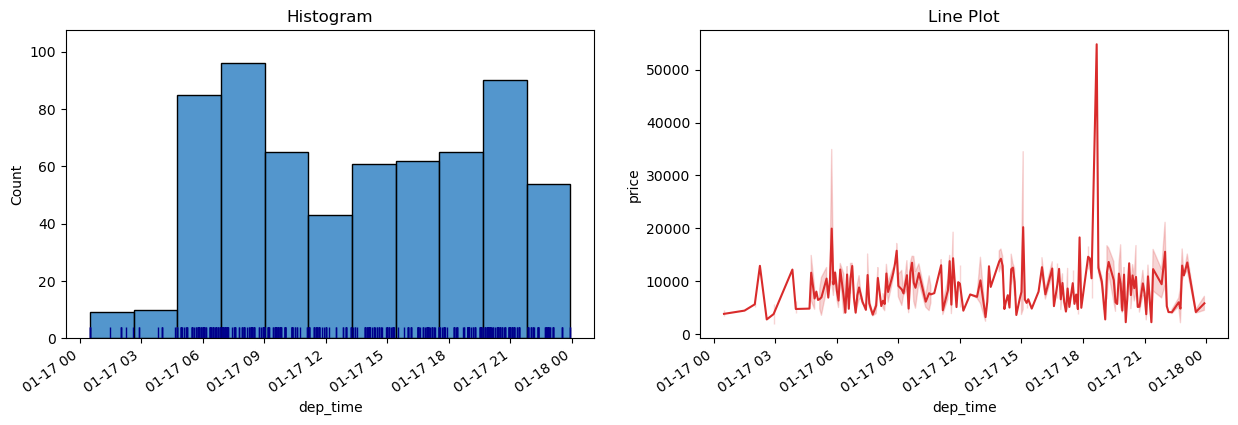

In [35]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

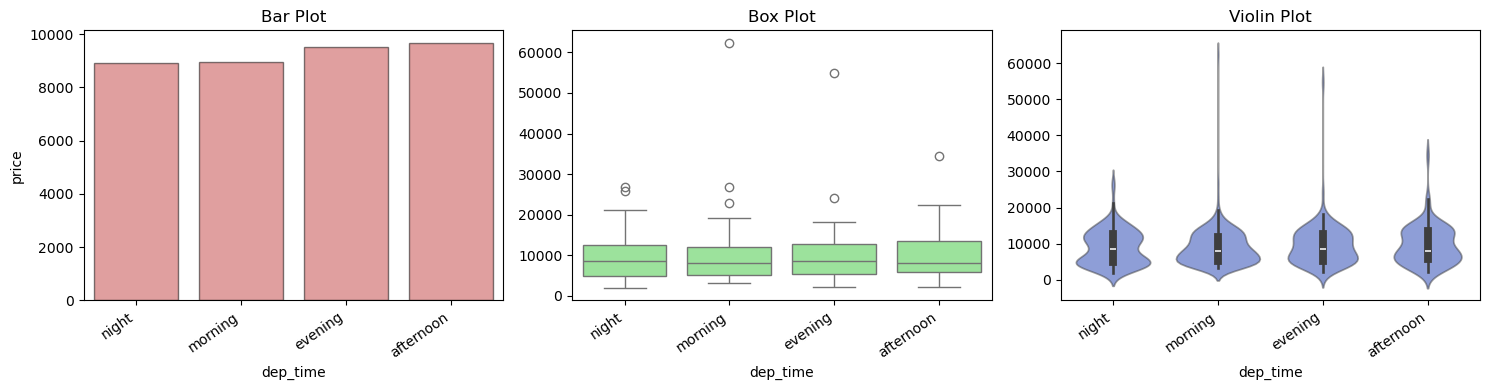

In [37]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

## Duration

In [38]:
train.duration

0       630
1       475
2       810
3      1325
4       180
       ... 
635     840
636     690
637     805
638     700
639     610
Name: duration, Length: 640, dtype: int64

In [39]:
eda_helper_functions.num_summary(train, "duration")

0       630
1       475
2       810
3      1325
4       180
       ... 
635     840
636     690
637     805
638     700
639     610
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,175.00
50,527.50
75,891.25
90,1431.00
95,1620.25
99,1748.05


,value
mean,634.664062
trimmed mean (5%),604.383681
trimmed mean (10%),575.292969
median,527.500000


,value
var,241519.018425
std,491.445845
IQR,716.250000
mad,352.500000
coef_variance,0.774340


,value
skewness,0.838092
kurtosis,-0.301226


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 5.167484929766563e-21
Test Statistic       : 0.8893230571585623
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 22.882251457877373
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [40]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    175.00
0.50    527.50
0.75    891.25
Name: duration, dtype: float64

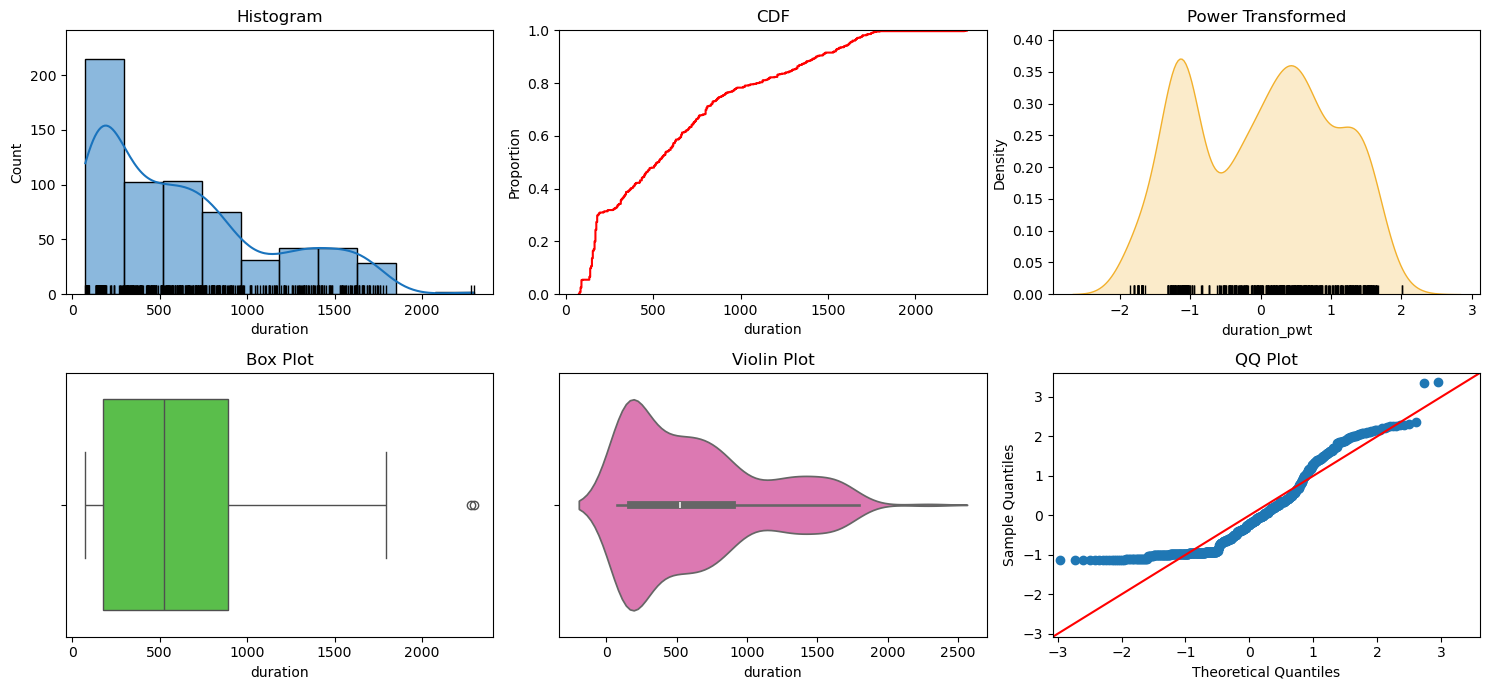

In [41]:
eda_helper_functions.num_univar_plots(train, "duration")

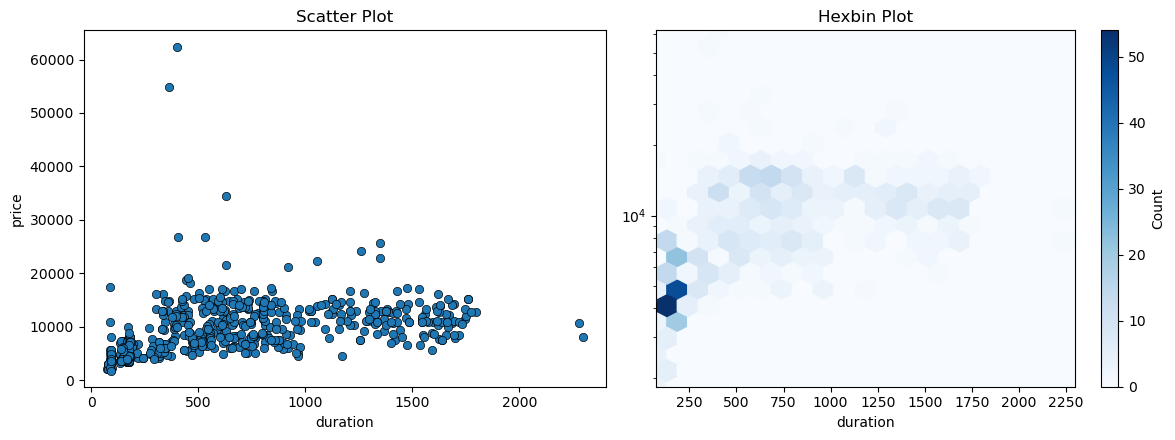

In [42]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [43]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.43805235817363214
- p-value              : 2.178347467010853e-31
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6923122672954498
- p-value              : 1.7813597939861186e-92
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


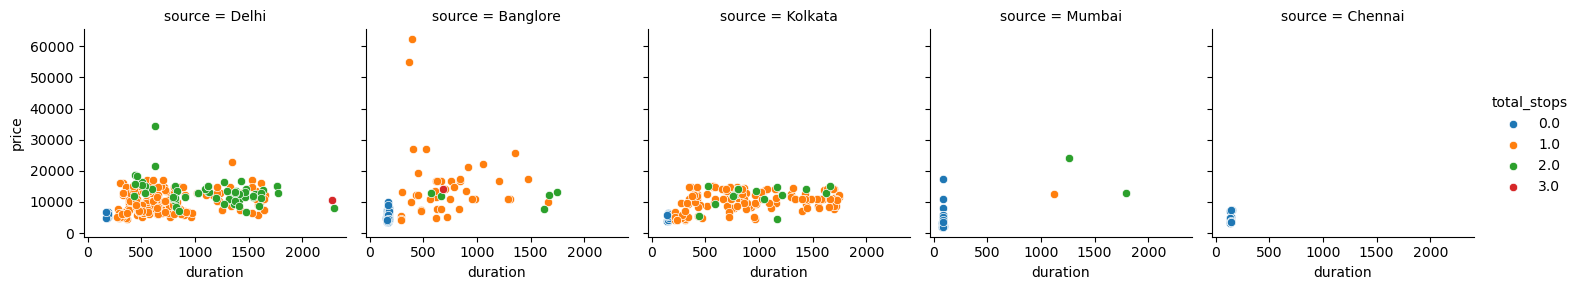

In [44]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

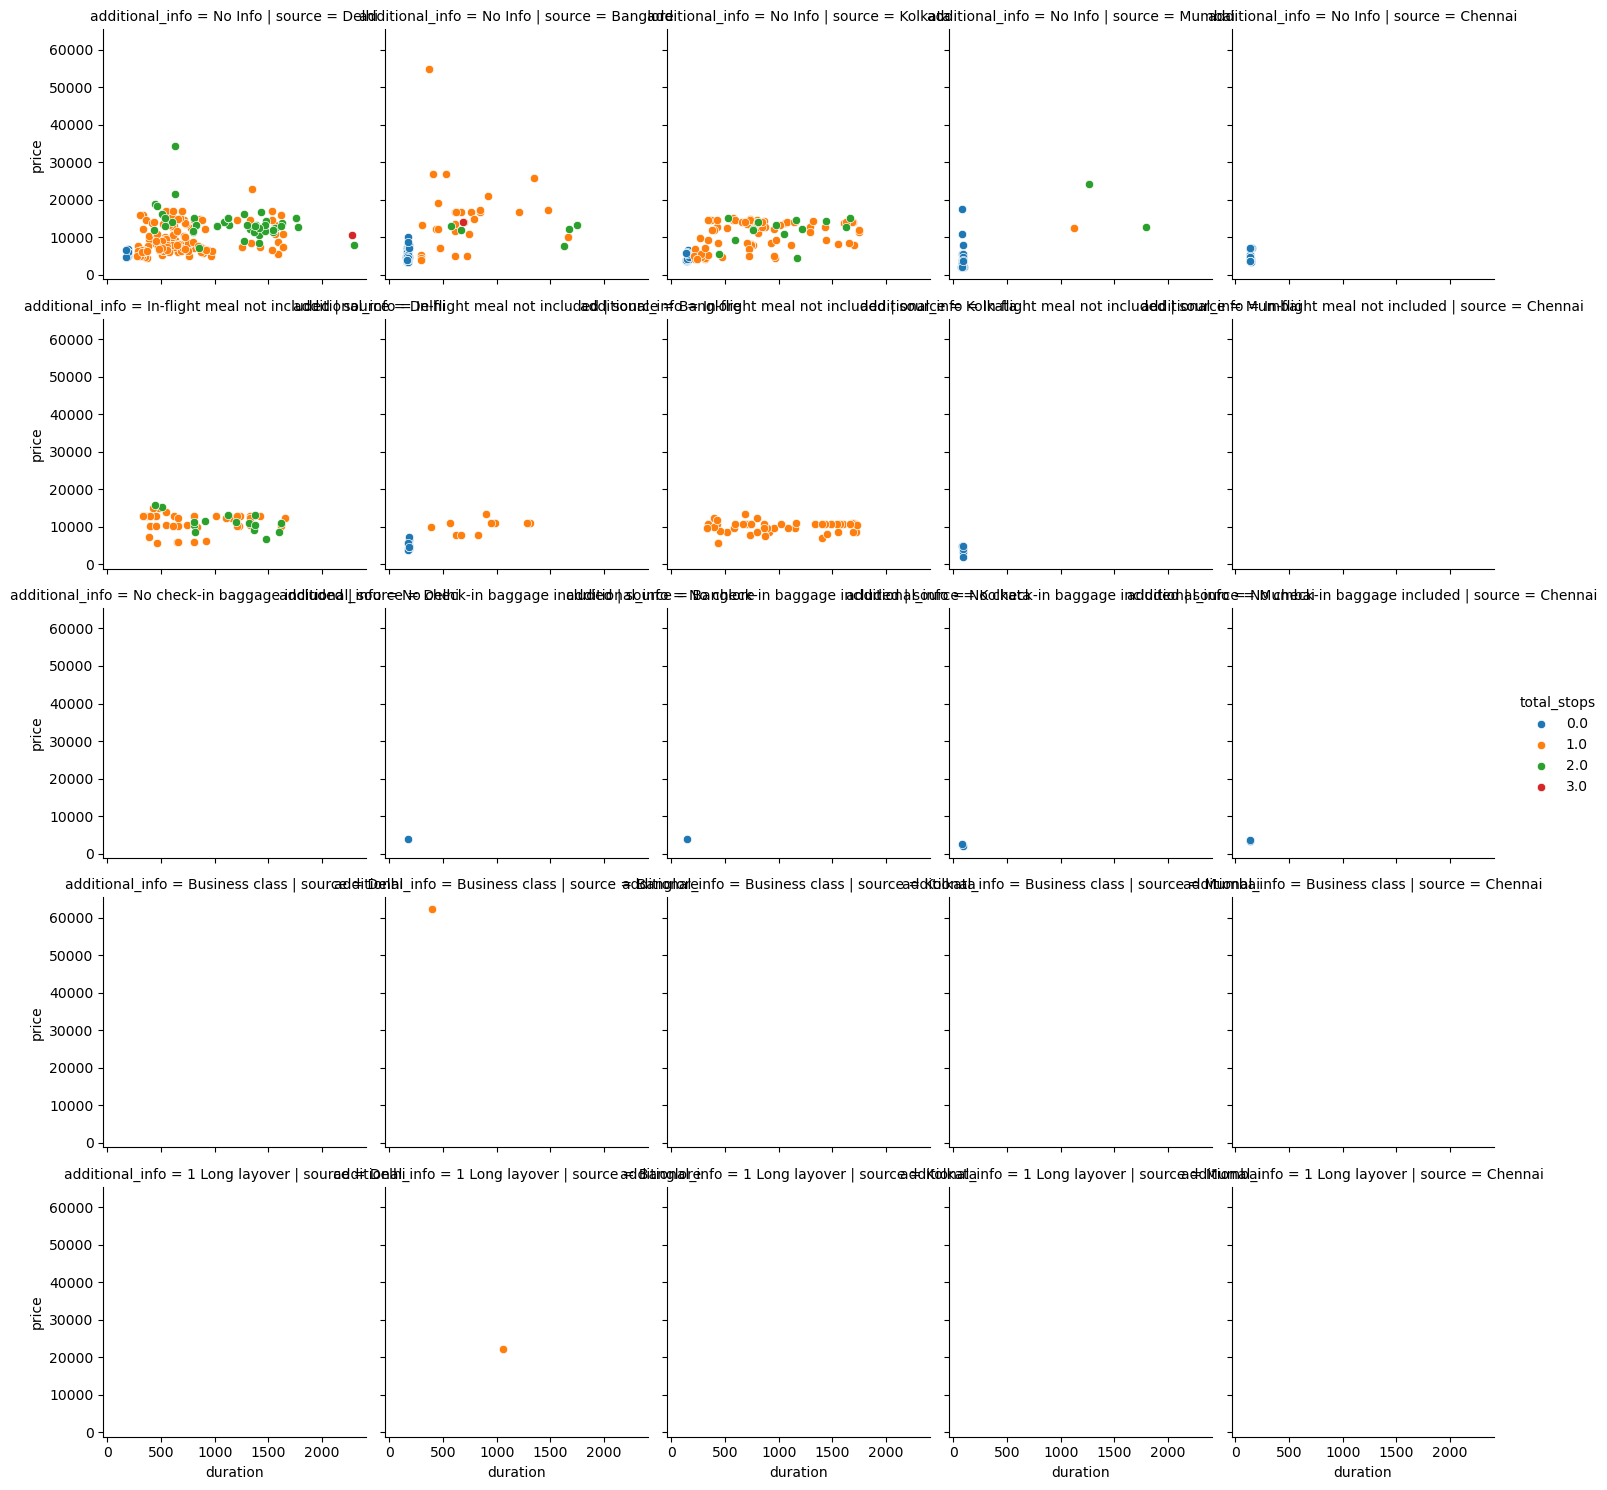

In [45]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [46]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -899.375
Upper Limit : 1965.625


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
217,Air India,2019-06-27,Delhi,Cochin,2026-01-17 05:15:00,2026-01-17 19:15:00,2280,3.0,No Info,10703
486,Air India,2019-03-27,Delhi,Cochin,2026-01-17 05:00:00,2026-01-17 19:15:00,2295,2.0,No Info,8026


## Additinal info

In [47]:
eda_helper_functions.cat_summary(train, "additional_info")

0                          No Info
1                          No Info
2      In-flight meal not included
3                          No Info
4      In-flight meal not included
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,5
top,No Info
freq,496


,count,percentage
category,,
No Info,496,0.775000
In-flight meal not included,136,0.212500
No check-in baggage included,6,0.009375
Business class,1,0.001563
1 Long layover,1,0.001563


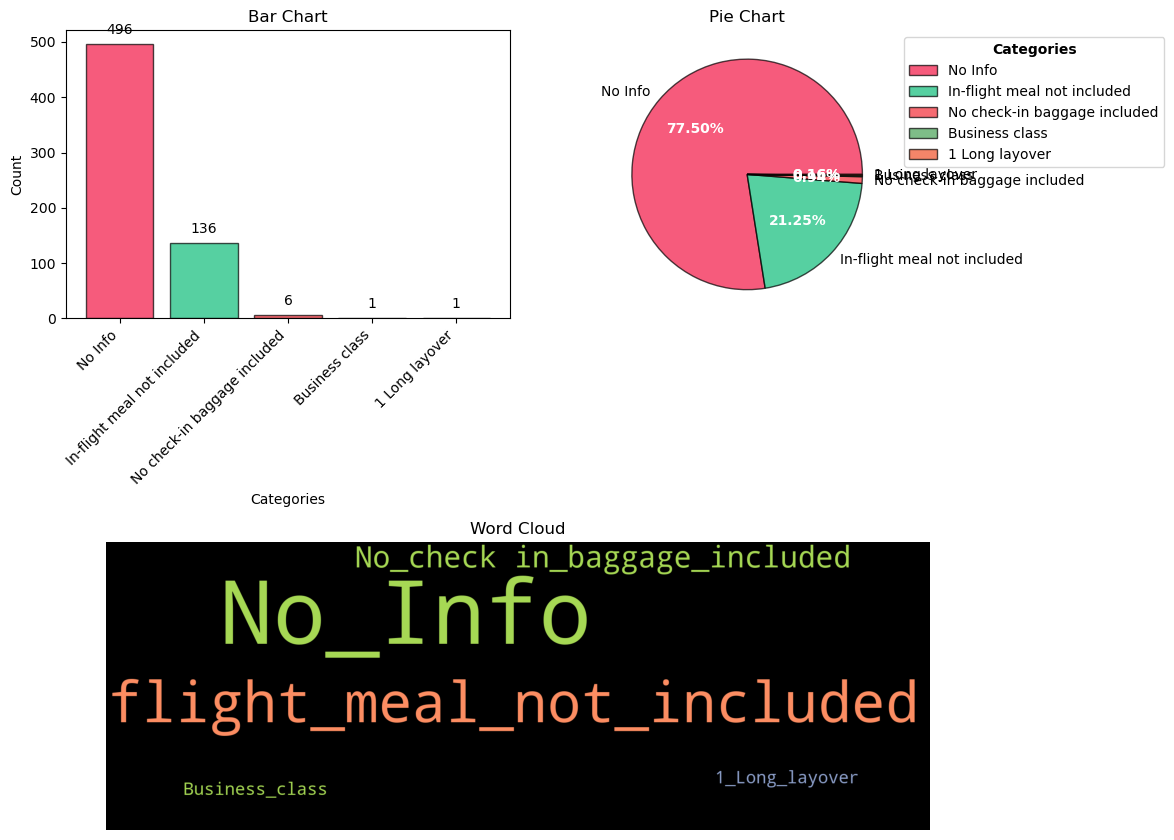

In [48]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

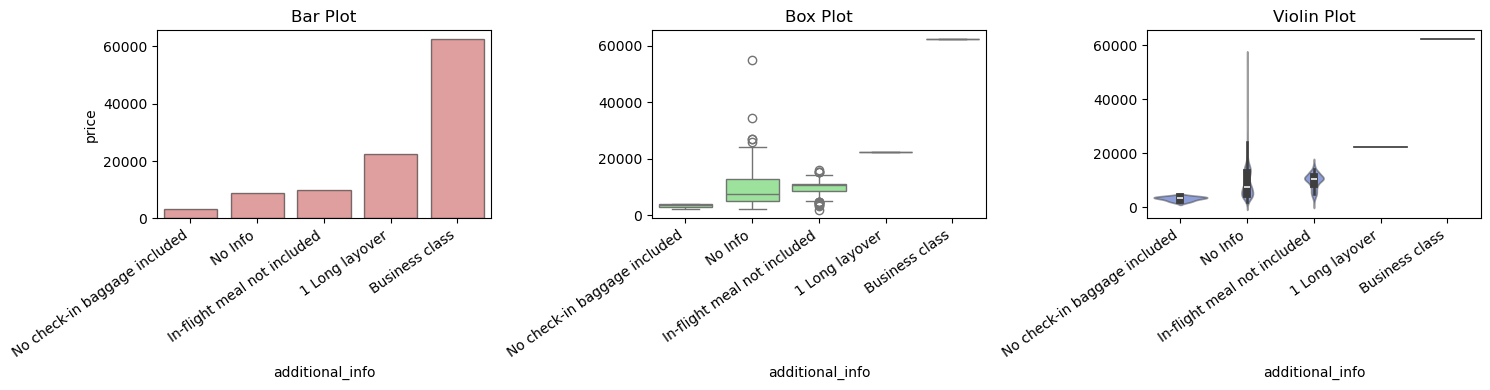

In [49]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

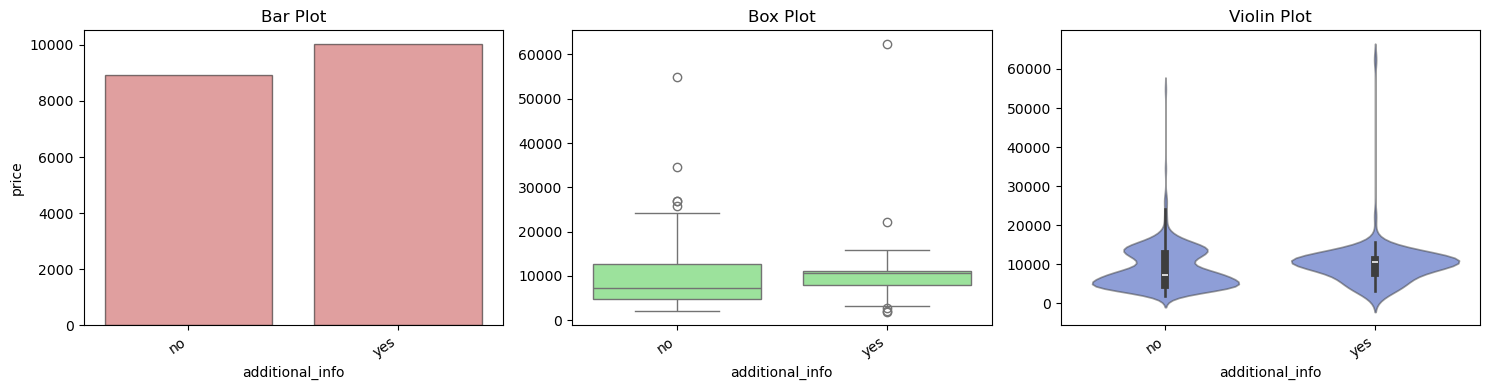

In [50]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

- additional_info has severely rare categories
- Converted it into a binary feature for further analysis

## Automated eDA

In [52]:
%pip install ydata-profiling

  Using cached pyyaml-6.0.3-cp311-cp311-win_amd64.whl.metadata (2.4 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------  7.9/8.0 MB 44.2 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 35.5 MB/s  0:00:00
   ---------------------------------------- 0.0/675.0 kB ? eta -:--:--
   ---------------------------------------- 675.0/675.0 kB 13.3 MB/s  0:00:00
Using cached pyyaml-6.0.3-cp311-cp311-win_amd64.whl (158 kB)
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   -------------------- ------------------- 1.6/3.1 MB 8.3 MB/s eta 0:00:01
   -------------------------- ------------- 2.1/3.1 MB 5.1 MB/s eta 0:00:01
   ------------------------------------ --- 2.9/3.1 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 3.1/3.1 MB 4.2 MB/s  0:00:00

   --- ------------------------------------  1/12 [minify-html]
   --- ------------------------------------  1/12 [minify-html]

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\users\\mukti\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf'
Consider using the `--user` option or check the permissions.



In [1]:
from ydata_profiling import ProfileReport

ModuleNotFoundError: No module named 'ydata_profiling'

In [53]:
report = ProfileReport(train)

NameError: name 'ProfileReport' is not defined

In [ ]:
report.to_file(output_file="output.html")